# Pairs Trading with Natural Language Processing
Jonathan Larkin

September 2017

This is the second post in a series on using Machine Learning in pairs trading. Pairs trading is perhaps the earliest form of relative value quantitative trading in equities. This series attempts to bring to bear some modern Machine Learning tools to the pair trading investment process. In the [first post](https://www.quantopian.com/posts/pairs-trading-with-machine-learning) of this series, I used `DBSCAN` clustering on latent statistical factors in price returns, the Morningstar `financial_health_grade`, and each company's market capitalization to find stocks which had a high likelihood of being valid eligible pairs in a pairs trading strategy. In this post, I take a very different path driven by the following question:

***Is it possible to find valid eligible pairs without using any price data at all?***

If we could do that, perhaps the process would be highly robust. From first principles, why do certain stocks have highly related price series (i.e., why could valid pairs exist)? I conjecture that it is because certain stocks:

- operate in similar business lines
- have similar economic exposures
- have similar regulatory burdens
- have a coincident set of homogenous investors
- operate in the same geographic markets

Therefore, if we could **read about and understand** the business of each company and then link up companies based on this understanding, we should have a robust set of potential eligible pairs. Human analysts are good at this kind of task, but can a machine do as well if not better? Well, this is a perfect task for Machine Learning, and, specifically, the sub-field of **Natural Language Processing.**

In this post, I:

1. gather business profiles on a couple thousand stocks,
2. utilize the `scikit-learn` natural language processing functionality `CountVectorizer` and `TfidfTransformer` to "read" these descriptions and extract important and novel concept features across all companies,
3. cluster stocks, again with `DBSCAN`, to find stocks that have similar profiles,
4. visualize the features for a handful of stocks via `WordCloud` to get some intuition on what the ML model is learning, and
5. lastly, inspect the time series of discovered clusters to see if this process, having no stock price series inputs at all, are related

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
study_date = '2017-09-06'

## 1. Gather Business Profiles
I have already gathered business profiles on thousands of stocks which we can bring into Quantopian with the `local_csv()` Research function. For reference, 
I used the [`pandas_finance`](https://github.com/davidastephens/pandas-finance) Python libary to query the [Profile tab](https://finance.yahoo.com/quote/KO/profile?p=KO) on Yahoo Finance. The Python code to gather the profiles is located [here](https://github.com/marketneutral/stock-cluster-nlp/blob/master/gather-profiles.ipynb). If you would like to use the data file yourself, you don't need to run that notebook however. The data file is located [here](https://github.com/marketneutral/stock-cluster-nlp/blob/master/profiles_20170907.csv). To use this data in Q Research, drag and drop it into your `data` directory. You must have this file in your `data` directory to run this notebook.

In [3]:
profiles_df = local_csv('profiles_20170907.csv', symbol_column='mstr_sym')
profiles_df.index = profiles_df['mstr_sym']
profiles_df = profiles_df[['profile']]
del profiles_df.index.name

For example, let's look at KO and PEP.

In [4]:
print profiles_df.loc[symbols('KO')]['profile']

The Coca-Cola Company, a beverage company, manufactures and distributes various nonalcoholic beverages worldwide. The company primarily offers sparkling beverages and still beverages. Its sparkling beverages include nonalcoholic ready-to-drink beverages with carbonation, such as carbonated energy drinks, and carbonated waters and flavored waters. The companys still beverages comprise nonalcoholic beverages without carbonation, including noncarbonated waters, flavored and enhanced waters, noncarbonated energy drinks, juices and juice drinks, ready-to-drink teas and coffees, and sports drinks. It also provides flavoring ingredients, sweeteners, beverage ingredients, and fountain syrups, as well as powders for purified water products. The Coca-Cola Company sells its products primarily under the Coca-Cola, Diet Coke/Coca-Cola Light, Coca-Cola Zero, Fanta, Sprite, Minute Maid, Georgia, Powerade, Del Valle, Schweppes, Aquarius, Minute Maid Pulpy, Dasani, Simply, Glacéau Vitaminwater, Gold P

In [5]:
print profiles_df.loc[symbols('PEP')]['profile']

PepsiCo, Inc. operates as a food and beverage company worldwide. Its Frito-Lay North America segment offers Lays and Ruffles potato chips; Doritos, Tostitos, and Santitas tortilla chips; and Cheetos cheese-flavored snacks, branded dips, and Fritos corn chips. The companys Quaker Foods North America segment provides Quaker oatmeal, grits, rice cakes, granola, and oat squares; and Aunt Jemima mixes and syrups, Quaker Chewy granola bars, Capn Crunch cereal, Life cereal, and Rice-A-Roni side dishes. Its North America Beverages segment offers beverage concentrates, fountain syrups, and finished goods under the Pepsi, Gatorade, Mountain Dew, Diet Pepsi, Aquafina, Diet Mountain Dew, Tropicana Pure Premium, Mist Twst, and Mug brands; and ready-to-drink tea and coffee, and juices. The companys Latin America segment provides snack foods under the Doritos, Cheetos, Marias Gamesa, Ruffles, Emperador, Saladitas, Sabritas, Lays, Rosquinhas Mabel, and Tostitos brands; cereals and snacks under th

### Join with Q1500 Universe

In [6]:
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.filters import Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

In [7]:
universe = Q1500US()

In [8]:
pipe = Pipeline(
    screen=universe
)

In [9]:
res = run_pipeline(pipe, study_date, study_date)
res.index = res.index.droplevel(0) 

In [10]:
res.head()

""
Equity(2 [ARNC])
Equity(24 [AAPL])
Equity(52 [ABM])
Equity(53 [ABMD])
Equity(62 [ABT])


In [11]:
profiles_df = pd.merge(res, profiles_df, left_index=True, right_index=True)

In [12]:
print "We have %d stocks in the universe with profiles." % len(profiles_df)

We have 1269 stocks in the universe with profiles.


## 2. Build Machine Learning Pipeline to Read the Profiles

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import DBSCAN

Natural Language Processing (NLP) itself has a lot of sub-fields: named entity recognition, natural language understanding, machine translation, sentiment analysis, etc. For our purposes we are interested in what I think is the simplest sub-field: document clustering. Document clustering is used in apps like Google News to show you articles related to the one you are reading. We have many stock profiles and we want to group together those which are very similar.

We will use `scikit-learn` classes: [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [`TfidfTransformer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to "read" the profiles.  This is the so called *bag of words* approach:

- Tokenize the text: break up the text into countable segments called *ngrams*.
- Count all the occurences of the tokens.
- Normalize the counts.

### Count Vectorizer
We give the `CountVectorizer` a block of text, and we get back a word count matrix with individual words on the column axis and each document along the rows. Actually, it doesn't count words, but counts *ngrams*. An *ngram* is a text fragment. For this analysis I use complete words but also bigrams and trigrams  (which are sequences of two words and three words respectively).

Let's see what `CountVectorizer` does on two "documents" to extract words and bigrams:

In [14]:
text = [
    "Quantopian inspires talented people everywhere to write investment algorithms.",
    "Select authors may license their algorithms to us and get paid based on performance."
]

In [15]:
vectorizer = CountVectorizer(
    analyzer='word',    # a single ngram is a "word": characters seperated by spaces
    ngram_range=(1,2)   # we care about ngrams with min length 1 and max length 2
)

In [16]:
# Transform the text
count_mat = vectorizer.fit_transform(text)

In [17]:
# Let's see the counts and all the ngrams across each document
zip(count_mat.toarray()[0], count_mat.toarray()[1], vectorizer.get_feature_names())

[(1, 1, u'algorithms'),
 (0, 1, u'algorithms to'),
 (0, 1, u'and'),
 (0, 1, u'and get'),
 (0, 1, u'authors'),
 (0, 1, u'authors may'),
 (0, 1, u'based'),
 (0, 1, u'based on'),
 (1, 0, u'everywhere'),
 (1, 0, u'everywhere to'),
 (0, 1, u'get'),
 (0, 1, u'get paid'),
 (1, 0, u'inspires'),
 (1, 0, u'inspires talented'),
 (1, 0, u'investment'),
 (1, 0, u'investment algorithms'),
 (0, 1, u'license'),
 (0, 1, u'license their'),
 (0, 1, u'may'),
 (0, 1, u'may license'),
 (0, 1, u'on'),
 (0, 1, u'on performance'),
 (0, 1, u'paid'),
 (0, 1, u'paid based'),
 (1, 0, u'people'),
 (1, 0, u'people everywhere'),
 (0, 1, u'performance'),
 (1, 0, u'quantopian'),
 (1, 0, u'quantopian inspires'),
 (0, 1, u'select'),
 (0, 1, u'select authors'),
 (1, 0, u'talented'),
 (1, 0, u'talented people'),
 (0, 1, u'their'),
 (0, 1, u'their algorithms'),
 (1, 1, u'to'),
 (0, 1, u'to us'),
 (1, 0, u'to write'),
 (0, 1, u'us'),
 (0, 1, u'us and'),
 (1, 0, u'write'),
 (1, 0, u'write investment')]

Generally we don't care about "common" words like "the", "a", "and", "on", etc. These words are not going to indicate anything novel in the corpus. The term for these words in NLP is *stop words*. `scikit-learn` contains a bunch of built-in stop words that we can use.

In [18]:
vectorizer = CountVectorizer(
    analyzer='word',    # a single ngram is a "word": characters separated by spaces
    ngram_range=(1,2),  # we care about ngrams with min lentgh 1 and max length 2
    stop_words='english'
)

In [19]:
# Transform the text
count_mat = vectorizer.fit_transform(text)

In [20]:
# Let's see the counts and all the ngrams across each document
zip(count_mat.toarray()[0], count_mat.toarray()[1], vectorizer.get_feature_names())

[(1, 1, u'algorithms'),
 (0, 1, u'algorithms paid'),
 (0, 1, u'authors'),
 (0, 1, u'authors license'),
 (0, 1, u'based'),
 (0, 1, u'based performance'),
 (1, 0, u'inspires'),
 (1, 0, u'inspires talented'),
 (1, 0, u'investment'),
 (1, 0, u'investment algorithms'),
 (0, 1, u'license'),
 (0, 1, u'license algorithms'),
 (0, 1, u'paid'),
 (0, 1, u'paid based'),
 (1, 0, u'people'),
 (1, 0, u'people write'),
 (0, 1, u'performance'),
 (1, 0, u'quantopian'),
 (1, 0, u'quantopian inspires'),
 (0, 1, u'select'),
 (0, 1, u'select authors'),
 (1, 0, u'talented'),
 (1, 0, u'talented people'),
 (1, 0, u'write'),
 (1, 0, u'write investment')]

That looks better. Now we have extracted the words and bigrams which are significant in the corpus. The only token which appears more than once in this corpus is "algorithms". Algorithms must be important to Quantopian...

Now let's run it on the company profiles.

In [21]:
# extract stop words so we can append our own
vect = CountVectorizer(stop_words='english')
stop_words = list(vect.get_stop_words())

# I am adding stop words which I do not expect to uniquely help determine stock similarity
# there are probably more to add
stop_words.extend(['founded', 'firm', 'company', 'llc', 'inc', 'incorporated'])

In [22]:
vect = CountVectorizer(
    analyzer='word',
    ngram_range=(1,3),
    strip_accents='unicode',
    max_features=3000,       # we limit the generation of tokens to the top 3000
    stop_words=stop_words
)

In [23]:
X = vect.fit_transform(profiles_df['profile'])
X

<1269x3000 sparse matrix of type '<type 'numpy.int64'>'
	with 110757 stored elements in Compressed Sparse Row format>

In [24]:
# let's see some features extracted
vect.get_feature_names()[1000:1030]

[u'factory',
 u'families',
 u'family',
 u'family residential',
 u'farm',
 u'farms',
 u'fashion',
 u'fasteners',
 u'features',
 u'february',
 u'federal',
 u'federal corporate',
 u'federal corporate income',
 u'federal income',
 u'federal income tax',
 u'fee',
 u'feed',
 u'feet',
 u'fertilizer',
 u'fiber',
 u'fiber optic',
 u'fiberglass',
 u'fibers',
 u'fidelity',
 u'fiduciary',
 u'field',
 u'fields',
 u'film',
 u'films',
 u'filters']

### Normalization with TF-IDF
The count frequency itself isn't likely to be enough to find pairs. Why? In document classification, words that appear frequently across *all* documents are probably not meaningful. For example, in our case, it is likely that the word "headquartered" appears frequently. Let's see.

In [25]:
test_word = 'headquartered'
occurences = sum(X[:, vect.get_feature_names().index(test_word)].toarray().flatten()>0)
total = X.shape[0]
print '%d of %d profiles contain the token "%s"!' % (occurences, total, test_word)

969 of 1269 profiles contain the token "headquartered"!


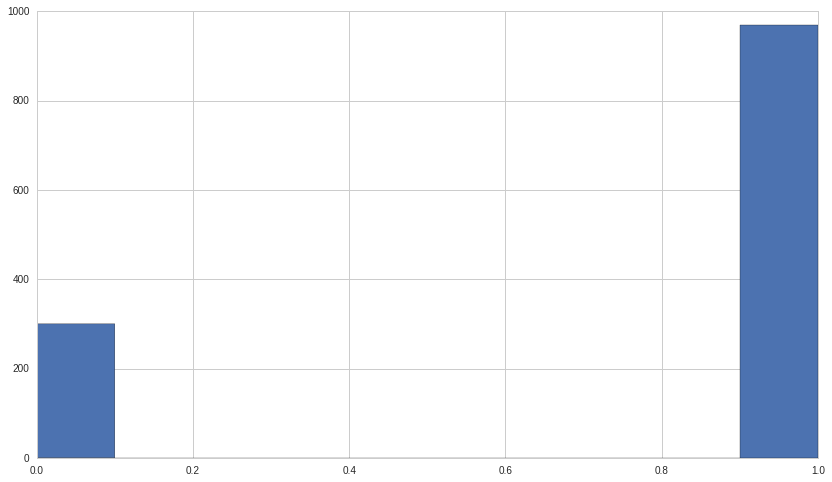

In [26]:
plt.hist(X[:, vect.get_feature_names().index(test_word)].todense());

The word "headquartered" is in many profiles. Clearly this is not going to be a good word to cluster against. Enter **TF-IDF**, which stands for "Term-Frequency times Inverse Document-Frequency".

Using the `TfidTransformer`, the *indivual token count frequency per document* (the "Term Frequency") is multiplied by a weighting
$$log \frac{1+n}{1+df(t)}+1$$
where $n$ is the total number of documents and $df(t)$ is the number of documents which contains the term $t$.

In [27]:
np.log(1+total)/(1+occurences)+1

1.0073678063705698

Hmmmmm. So multiplying by ~1.0 doesn't make a difference, but the key is that *all* tokens are multiplied by this function. This overweights infrequently occurring tokens *across* documents. The idea is that words which infrequently occur across *all documents* are signposts of novelty for the documents within which they do occur. We can see the impact of this function as:

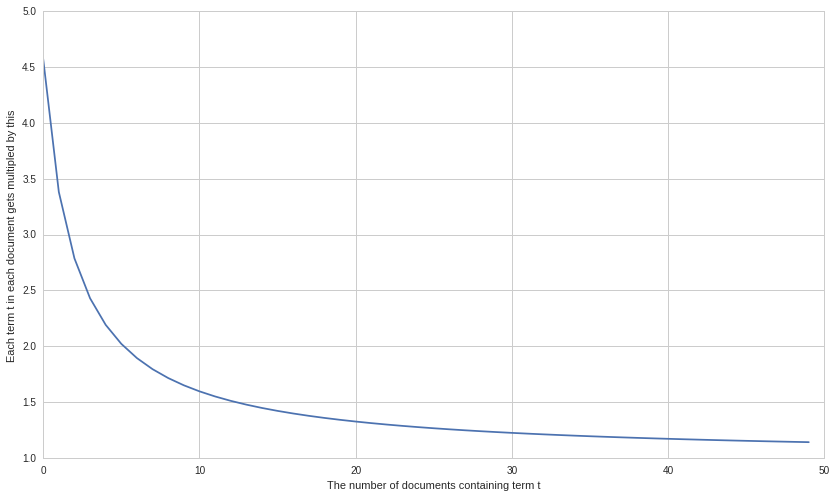

In [28]:
plt.plot((np.log(1+total)/(1+np.linspace(1,50))) + 1);
plt.xlabel("The number of documents containing term t");
plt.ylabel("Each term t in each document gets multipled by this");

This should not be confused with scaling based on the counts *within* documents. That feature is controlled by the flag `sublinear_tf`. If this flag is `true` then each count *within* a document is scaled by $1+log(c)$, where $c$ is the count within the document. For example, if one profile said "...Energy company...energy markets...energy demand", the count of "energy" would be scaled up in that profile. We don't use this scaling in this case.

One might ask, if this word is meaningless, why not just add it to the stop words? We don't want to do that because, although "headquartered" alone is not meaningful, *maybe* the phrase "headquartered in New York" *is* meaningful.

In [29]:
test_word = 'headquartered new york'  # "in" is a stop word, so we ignore it
occurences = sum(X[:, vect.get_feature_names().index(test_word)].toarray().ravel()>0)
total = X.shape[0]
print '%d of %d profiles contain the token "%s"!' % (occurences, total, test_word)

54 of 1269 profiles contain the token "headquartered new york"!


In [30]:
# transform the count matrix
tfidf = TfidfTransformer()
X_idf = tfidf.fit_transform(X)
X_idf

<1269x3000 sparse matrix of type '<type 'numpy.float64'>'
	with 110757 stored elements in Compressed Sparse Row format>

## 3. Cluster Stocks Based on the TF-IDF Matrix
As in the previous post, I use the [`DBSCAN` clustering algorithm](http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#dbscan). This is an ideal algorithm to cluster pairs because:

- we don't need to specify the number of clusters, and
- it does *not* cluster all stocks. This feature is important because we would not expect *all* stocks to have a closely related sibling.

After `DBSCAN` I use a second pass to only include clusters that have two stocks; i.e., we only take clusters that are tight enough to have just two stocks.

In [31]:
clf = DBSCAN(eps=1.05, min_samples=2)
labels = clf.fit_predict(X_idf)

In [32]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print "\nTotal custers discovered: %d" % n_clusters_

clustered = labels


Total custers discovered: 99


In [33]:
clustered_series = pd.Series(index=profiles_df.index, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

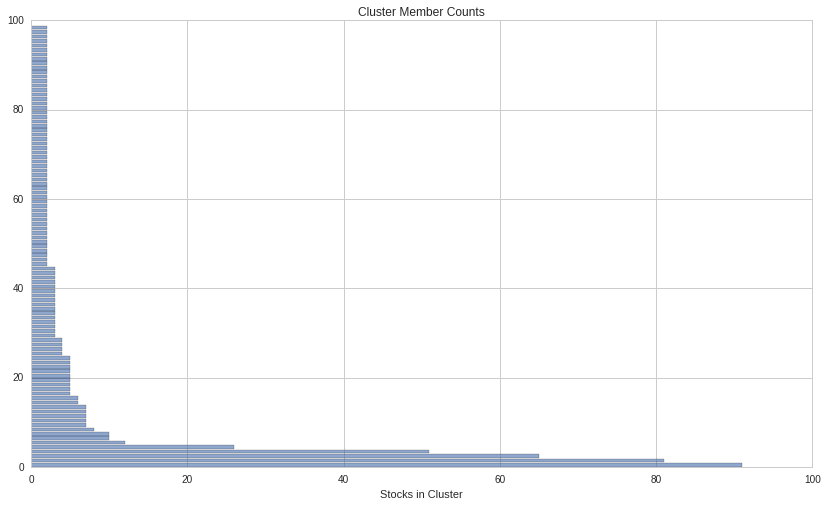

In [34]:
plt.barh(
    xrange(len(clustered_series.value_counts())),
    clustered_series.value_counts(),
    alpha=0.625
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster');

In [35]:
pair_clusters = clustered_series.value_counts()[clustered_series.value_counts()<3].index.values

In [36]:
print pair_clusters
print "\nTotal pair clusters discovered: %d" % len(pair_clusters)

[18 12 21 10 36 41 23  4  3  1 25 98 42 85 76 77 78 79 80 81 82 84 86 43 87
 90 91 92 93 94 95 96 73 72 71 70 46 47 97 50 51 52 54 55 56 58 60 61 62 64
 66 68 69 49]

Total pair clusters discovered: 54


Let's look at the profile descriptions of a pair that we have discovered.

In [37]:
cluster = clustered_series[symbols('CDNS')]
profiles_df.iloc[clustered==cluster]

,profile
Equity(1385 [CDNS]),"Cadence Design Systems, Inc. provides electron..."
Equity(6994 [SNPS]),"Synopsys, Inc. provides electronic design auto..."


In [38]:
print profiles_df.iloc[clustered==cluster].iloc[0,0]

Cadence Design Systems, Inc. provides electronic design automation software, emulation and prototyping hardware, system interconnect, and analysis worldwide. It offers functional verification, including emulation and prototyping hardware. Its functional verification offering consists of JasperGold, a formal verification platform; Incisive, a functional verification platform; and Palladium, a verification computing platform. The company also provides digital integrated circuit (IC) design products, such as logic design products for chip planning, design, verification, and test technologies and services; physical implementation tools, including place and route, signal integrity, optimization, and multiple patterning preparation; and signoff products to signoff the design as ready for manufacture by a silicon foundry, as well as design for manufacturing products for use in the product development process. In addition, it offers custom IC design and verification products to create schemati

In [39]:
print profiles_df.iloc[clustered==cluster].iloc[1,0]

Synopsys, Inc. provides electronic design automation (EDA) software products used to design and test integrated circuits (ICs). It offers Galaxy Design platform that provides IC design solutions; Verification Continuum Platform, which offers virtual prototyping, static and formal verification, simulation, emulation, field-programmable gate array (FPGA)-based prototyping, and debug solutions; and FPGA design products that are programmed to perform specific functions. The company also provides DesignWare intellectual property (IP) solutions for USB, PCI Express, DDR, Ethernet, SATA, MIPI, HDMI, and Bluetooth low energy applications; analog IP, including data converters and audio codecs; and system-on-chip infrastructure IP, datapath and building block IP, and verification IP products, as well as mathematical and floating point components, and ARM AMBA interconnect fabric and peripherals. In addition, it offers logic libraries and embedded memories; configurable processor cores and applic

## 4. Visualize What the ML Model Learned

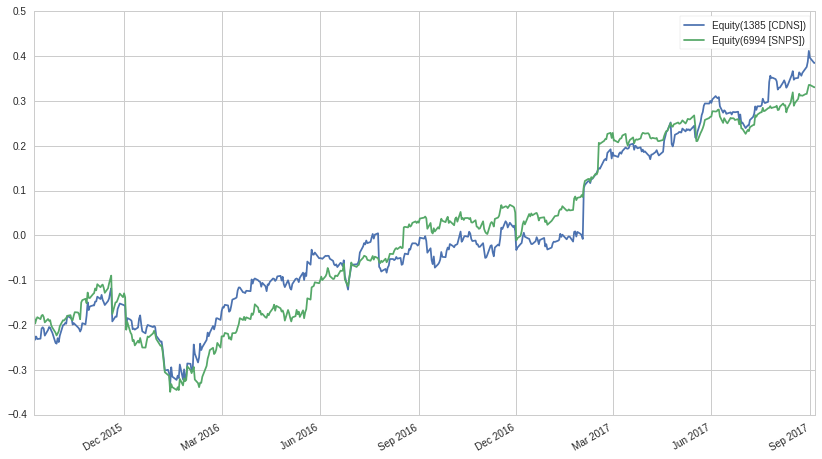

In [40]:
def plot_cluster(which_cluster, plot_mean=False):
    pricing = get_pricing(
        symbols=[profiles_df.iloc[clustered==which_cluster].index],
        fields='close_price',
        start_date=pd.Timestamp(study_date) - pd.DateOffset(months=24),
        end_date=pd.Timestamp(study_date)
    )
    means = np.log(pricing).mean()
    data = np.log(pricing).sub(means)
    
    if plot_mean:
        means = data.mean(axis=1).rolling(window=21).mean().shift(1) #.plot()
        data.sub(means, axis=0).plot()
        plt.axhline(0, lw=3, ls='--', label='mean', color='k')
        plt.legend(loc=0)
    else:
        data.plot()
plot_cluster(cluster)

That's pretty amazing to me. Just by looking a text description of companies, 1) the ML model was able to find related companies, *and* 2) related companies do indeed seem to have related price series. What is the ML model learning? I generated some [word clouds](https://github.com/amueller/word_cloud) on the results. My code to do this is [here](https://github.com/marketneutral/stock-cluster-nlp/blob/master/viz_clouds.ipynb).

![image](https://image-proxy.quantopian.com/2c4820e459ed9ab1b2181217b3a003196279d1f7/68747470733a2f2f6769746875622e636f6d2f6d61726b65746e65757472616c2f73746f636b2d636c75737465722d6e6c702f7261772f6d61737465722f43444e535f534e50532e706e67)

The world cloud shows the text features that the ML model thinks are important; the size of a feature indicates the importance of that feature as returned by the `TfidfTransformer` across all stocks. Since we are using up to three ngrams, I added a "+" to indicate terms with a multi-token feature.

### Four Other Examples
I pulled out a sample of others which look to have very strong pair relationships as well.

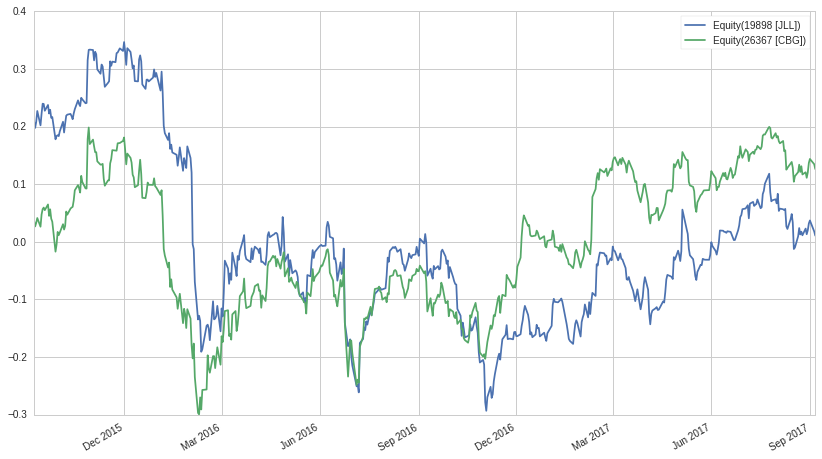

In [41]:
cluster = clustered_series[symbols('JLL')]
plot_cluster(cluster)

![image](https://image-proxy.quantopian.com/f92ecf27cd347ca143ad4259979db0db5998ea54/68747470733a2f2f6769746875622e636f6d2f6d61726b65746e65757472616c2f73746f636b2d636c75737465722d6e6c702f7261772f6d61737465722f4a4c4c5f4342472e706e67)

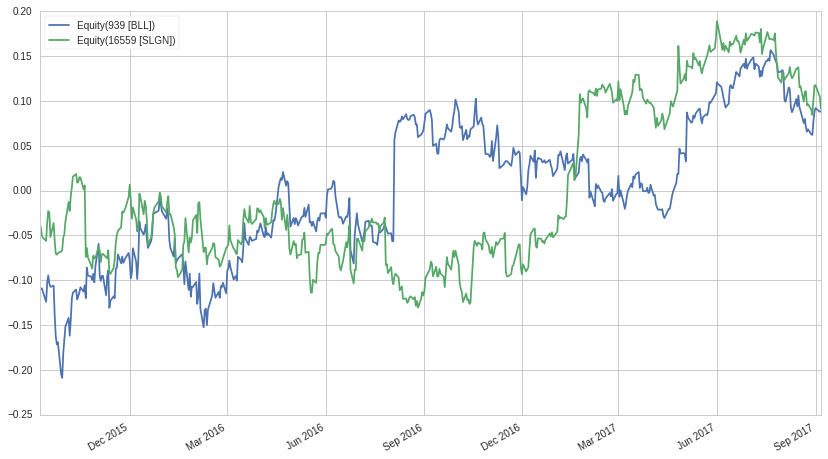

In [42]:
cluster = clustered_series[symbols('SLGN')]
plot_cluster(cluster)

![image](https://image-proxy.quantopian.com/a7ea0f6b4da216c482578bed525853a67b668e5a/68747470733a2f2f6769746875622e636f6d2f6d61726b65746e65757472616c2f73746f636b2d636c75737465722d6e6c702f7261772f6d61737465722f424c4c5f534c474e2e706e67)

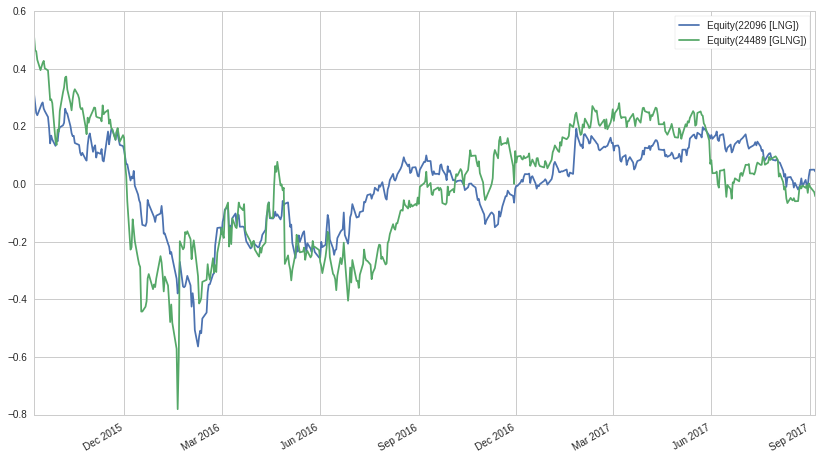

In [43]:
cluster = clustered_series[symbols('LNG')]
plot_cluster(cluster)

![image](https://image-proxy.quantopian.com/c574046934421e57d3942a9eaf0681fba3f2e0ae/68747470733a2f2f6769746875622e636f6d2f6d61726b65746e65757472616c2f73746f636b2d636c75737465722d6e6c702f7261772f6d61737465722f4c4e475f474c4e472e706e67)

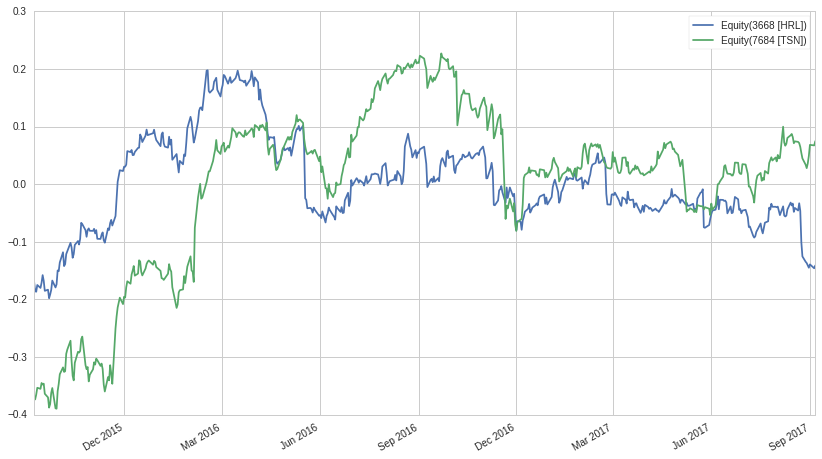

In [44]:
cluster = clustered_series[symbols('HRL')]
plot_cluster(cluster)

![image](https://image-proxy.quantopian.com/52d0748b1bded6233791bb65d8f96f33f8e418fb/68747470733a2f2f6769746875622e636f6d2f6d61726b65746e65757472616c2f73746f636b2d636c75737465722d6e6c702f7261772f6d61737465722f48524c5f54534e2e706e67)

### Larger Clusters
This post was initially intended only to be about pairs trading, narrowly defined. Thomas Wiecki pointed out to me though that the larger clusters may exhibit a tight relationship as well and thus could be used in a less restricted algorithm setting.

Above we only looked at clusters of size 2, but what about the larger ones? They could be co-integrated too. In fact, identifying larger number of stocks that are co-integrated allows us to extend the idea of pairs-trading: Rather than assuming that the price of two stocks will converge again after some time, we can instead assume that the price of any stock in the cluster, will converge back to the rolling mean price of the whole cluster.  

In [45]:
def plot_cluster_relative_to_mean(which_cluster):
    pricing = get_pricing(
        symbols=[profiles_df.iloc[clustered==which_cluster].index],
        fields='close_price',
        start_date=pd.Timestamp(study_date) - pd.DateOffset(months=24),
        end_date=pd.Timestamp(study_date)
    )
    means = np.log(pricing).mean()
    data = np.log(pricing).sub(means)
    
    means = data.mean(axis=1).rolling(window=21).mean().shift(1) # shift to avoid look-ahead bias
    data.sub(means, axis=0).plot()
    plt.axhline(0, lw=3, ls='--', label='mean', color='k')
    plt.ylabel('Price divergence from group mean')
    plt.legend(loc=0)

In [46]:
large_clusters = clustered_series.value_counts()[clustered_series.value_counts()>=3].index.values

In [47]:
print large_clusters
print "\nTotal large clusters discovered: %d" % len(pair_clusters)

[31  6 15  5  7 14 33 11 17 28 19 32 26 38 29 48 74 65 53 63  8 37 30  9 57
 45 35 75 16 39 59 44 27 34  0 22 83 13  2 89 88 67 40 20 24]

Total large clusters discovered: 54


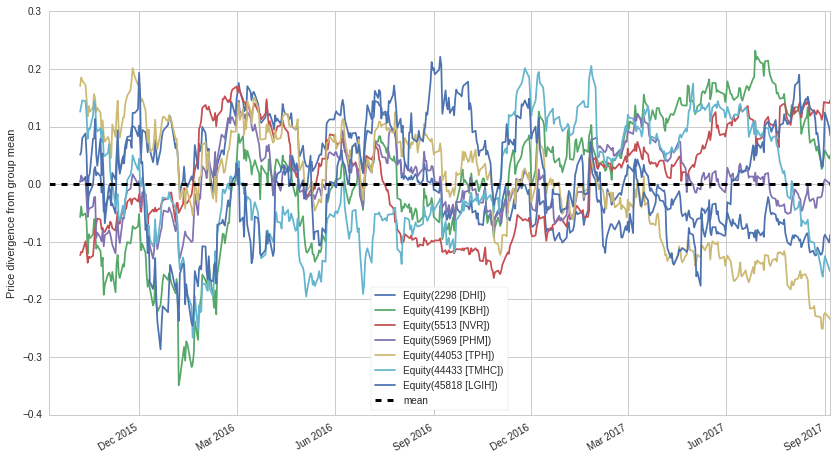

In [48]:
cluster = clustered_series[symbols('DHI')]
plot_cluster_relative_to_mean(cluster)

![image](https://image-proxy.quantopian.com/808308f88eebc8846efa2d6bce5b9631f4f53b73/68747470733a2f2f6769746875622e636f6d2f6d61726b65746e65757472616c2f73746f636b2d636c75737465722d6e6c702f7261772f6d61737465722f4448495f6c617267655f636c7573746572322e706e67)

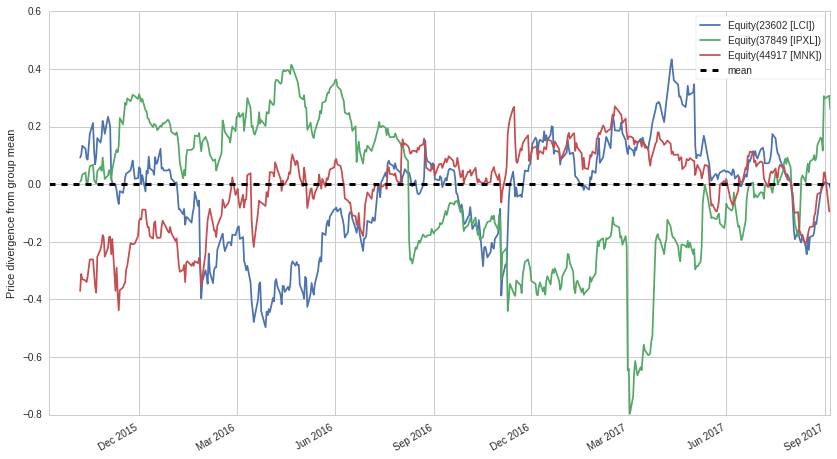

In [49]:
cluster = clustered_series[symbols('LCI')]
plot_cluster_relative_to_mean(cluster)

![image](https://image-proxy.quantopian.com/cf82c8decee1c5642f33c26bc848f0b402b7a3ae/68747470733a2f2f6769746875622e636f6d2f6d61726b65746e65757472616c2f73746f636b2d636c75737465722d6e6c702f7261772f6d61737465722f4c43495f6c617267655f636c75737465722e706e67)

## Conclusion
The search space to find valid pairs for a pairs trading strategy is vast. As researchers, we can add a lot of value by intelligently reducing this search space. "Machine Learning plus data" has a lot of value to add in this search. The majority of examples I see posted across the web for Machine Learning in finance attempt to predict future stock prices by training on past prices. This is unlikely to be successful out-of-sample as the signal-to-noise ratio in price data is very low and financial time series are non-stationary. Machine Learning though can help significantly to make an investment process smarter and faster and, as this example shows, uncover relationships embedded in unstructured data. This post also demonstrates how you can bring in your own data to Quantopian Research tackle the pairs search problem. 

*Thanks to Thomas Wiecki for contributing to the "Larger Clusters" section and to Max Margenot for his review.*

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*